In [1]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleParticles
from diffSPH.v2.util import countUniqueEntries, printState
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep

from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep    
from diffSPH.v2.modules.viscosity import computeViscosityParameter, setViscosityParameters
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
import os
import datetime
from diffSPH.v2.util import computeStatistics
import tomli

from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict
from diffSPH.v2.sampling import find_contour
from diffSPH.v2.sampling import sampleParticles, processBoundarySDFs, generateInitialParticles
from diffSPH.v2.plotting import setPlotBaseAttributes, plotRegions
from diffSPH.v2.plotting import visualizeParticleQuantity, prepVisualizationState
from diffSPH.v2.modules.mDBC import buildBoundaryGhostParticles
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict

In [2]:
configurationFile = './configurations/02_outlet.toml'

with open(configurationFile, 'r') as f:
    config = f.read()

config = tomli.loads(config)

In [3]:
config['domain']

{'adjustParticle': False, 'adjustDomain': False, 'dim': 2, 'periodic': True}

In [4]:
nx = 128
L = 1
u_mag = 2
k = 1 * np.pi
TGV_override = False
targetRe = 1000

config['domain']['minExtent'] = [-2,-2]
config['domain']['maxExtent'] =  [2,2]
config['domain']['periodic'] = False

config['boundary']['active'] = True

config['particle'] = {'nx' : nx}
config['fluid'] = {'cs' : u_mag * 10}
config['compute'] = {'device': 'cpu', 'checkNaN': True}


config = parseDefaultParameters(config)
config = parseModuleParameters(config)
setViscosityParameters(config, targetRe, L, u_mag)
config['diffusion']['alpha'] = 0.01
config['diffusion']['pi-switch']=False
config['gravity']['active'] = True
config['EOS']['type'] = 'stiffTait'

print(rf'Re = {config["diffusion"]["Re"]}, $\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$, $\alpha = {config["diffusion"]["alpha"]}$')


Re = 999.9999389648438, $\nu_{sph} = 0.004000000189989805$, $\alpha = 0.01$


In [5]:
# from diffSPH.v2.sampling import sampleNoisyParticles
# from diffSPH.v2.modules.divergence import computeDivergence
# from diffSPH.v2.plotting import plotSDF
# from diffSPH.v2.sdf import getSDF, operatorDict

# ngrid = 255
# x = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
# y = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
# X, Y = torch.meshgrid(x, y, indexing = 'ij')
# P = torch.stack([X,Y], dim=-1)
# points = P.reshape(-1,2)

# sphere_a = lambda points: getSDF('hexagon')['function'](points, 1/3)
# sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/3,1/3]).to(points.device))
# translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.25]))
# rotated = operatorDict['rotate'](translated, 0.5)
# sdf = operatorDict['smooth_union'](rotated, sphere_a, 0.25)

# # circle_a = operatorDict['translate'](lambda points: getSDF('hexagon')['function'](points, 0.35), torch.tensor([-0.25,0.]))
# # circle_b = operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.35), torch.tensor([ 0.25,0.]))
# # sdf = operatorDict['smooth_union'](circle_a, circle_b, 0.05)
# # sdf = operatorDict['twist'](sdf, 0.5)
# # sdf = operatorDict['shell'](sdf, 0.125)
# sdf = sphere_a
# plotSDF(sdf(torch.clone(points.to('cuda')),), X.to('cuda'), Y.to('cuda'), 2, 2)

In [6]:


ngrid = 255
x = torch.linspace(config['domain']['minExtent'][0], config['domain']['maxExtent'][0], ngrid, dtype = torch.float32)
y = torch.linspace(config['domain']['minExtent'][1], config['domain']['maxExtent'][1], ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('hexagon')['function'](points, 1/3)
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/3,1/3]).to(points.device))
translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.25]))
rotated = operatorDict['rotate'](translated, 0.5)
sdf = operatorDict['smooth_union'](rotated, sphere_a, 0.25)

fluid_sdf = sphere_a
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([2,1/6]).to(points.device))
translated = operatorDict['translate'](sphere_b, torch.tensor([0.0,-1/2 - 1/6]))
boundary_sdf = translated


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1/2]).to(points.device))
inletSDF = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1]).to(points.device))
outletSDF = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/4,1.5]).to(points.device))
outletRegion = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/4,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)


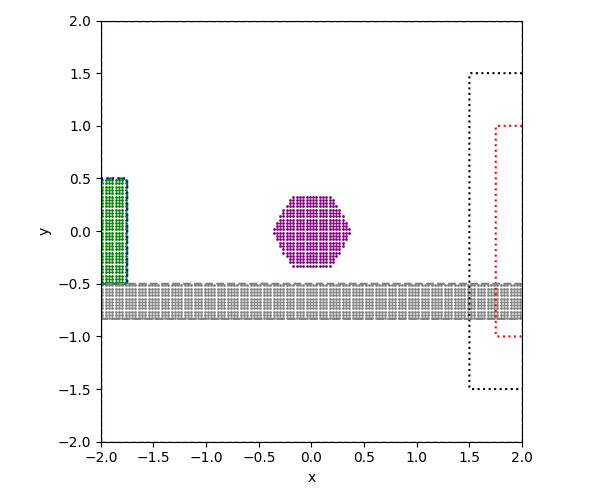

In [7]:
config['regions'] = [{
        'sdf': inletSDF,
        'type': 'inlet',
        'velocity': torch.tensor([1,0.]),
        'particles': sampleParticles(config, sdfs = [inletSDF])[0],
        'contour': find_contour(inletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    },
    {
        'sdf': inletSDF,
        'type': 'forcing',
        'forcingMode': 'immediate',
        'velocity': torch.tensor([1,0.]),
        'particles': sampleParticles(config, sdfs = [inletSDF])[0],
        'contour': find_contour(inletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    },{
        'sdf': outletSDF,
        'type': 'outlet',
        'velocity': torch.tensor([0.,0.]),
        'particles': sampleParticles(config, sdfs = [outletSDF])[0],
        'contour': find_contour(outletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    },{
        'sdf': outletRegion,
        'type': 'mirror',
        'velocity': torch.tensor([0.,0.]),
        'particles': sampleParticles(config, sdfs = [outletRegion])[0],
        'contour': find_contour(outletRegion(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    },{
        'sdf': boundary_sdf,
        'type': 'boundary',
        'velocity': torch.tensor([0.,0.]),
        'particles': sampleParticles(config, sdfs = [boundary_sdf])[0],
        'contour': find_contour(boundary_sdf(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    },{
        'sdf': fluid_sdf,
        'type': 'fluid',
        'velocity': torch.tensor([1.,0.]),
        'particles': sampleParticles(config, sdfs = [fluid_sdf])[0],
        'contour': find_contour(fluid_sdf(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    }
    ]


fig, axis = plt.subplots(1,1, figsize = (6,5), squeeze = False)
setPlotBaseAttributes(axis[0,0], config)

plotRegions(config['regions'], axis[0,0])

fig.tight_layout()

In [8]:



particleState = generateInitialParticles(config)
perennialState = copy.deepcopy(particleState)

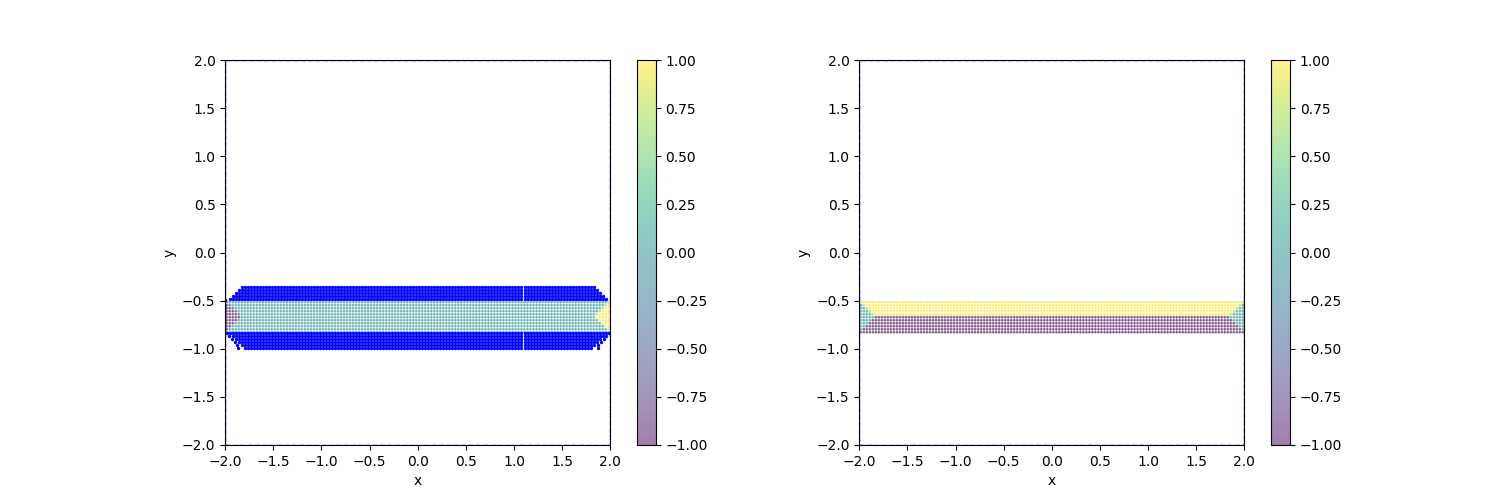

In [9]:
fig, axis = plt.subplots(1,2, figsize = (15,5), squeeze = False)
setPlotBaseAttributes(axis[0,0], config)
setPlotBaseAttributes(axis[0,1], config)

visualizationState = prepVisualizationState(perennialState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

# sc = axis[0,0].scatter(perennialState['fluid']['positions'][:,0].detach().cpu().numpy(), perennialState['fluid']['positions'][:,1].detach().cpu().numpy(), c = 'black', marker = 'x', s = 1, alpha = 0.5)

# sc2 = axis[0,0].scatter(perennialState['boundary']['positions'][:,0].detach().cpu().numpy(), perennialState['boundary']['positions'][:,1].detach().cpu().numpy(), c = perennialState['boundary']['distances'].detach().cpu().numpy(), marker = 'o', s = 1, alpha = 0.5)
boundaryGhostState = buildBoundaryGhostParticles(perennialState, config)
# perennialState['boundaryGhost'] = boundaryGhostState
ghostParticlePositions = boundaryGhostState['positions']
boundaryParticlePositions = perennialState['boundary']['positions'] 
# ghostParticlePositions = boundaryParticlePositions - 2 * perennialState['boundary']['distances'].view(-1,1) * perennialState['boundary']['normals'] 

sc1 = axis[0,0].scatter(perennialState['boundary']['positions'][:,0].detach().cpu().numpy(), perennialState['boundary']['positions'][:,1].detach().cpu().numpy(), c = perennialState['boundary']['normals'][:,0].detach().cpu().numpy(), marker = 'o', s = 1, alpha = 0.5)
sc2 = axis[0,1].scatter(perennialState['boundary']['positions'][:,0].detach().cpu().numpy(), perennialState['boundary']['positions'][:,1].detach().cpu().numpy(), c = perennialState['boundary']['normals'][:,1].detach().cpu().numpy(), marker = 'o', s = 1, alpha = 0.5)

sc = axis[0,0].scatter(ghostParticlePositions[:,0].detach().cpu().numpy(), ghostParticlePositions[:,1].detach().cpu().numpy(), c = 'blue', marker = 'o', s = 2)

fig.colorbar(sc1, ax = axis[0,0])
fig.colorbar(sc2, ax = axis[0,1])


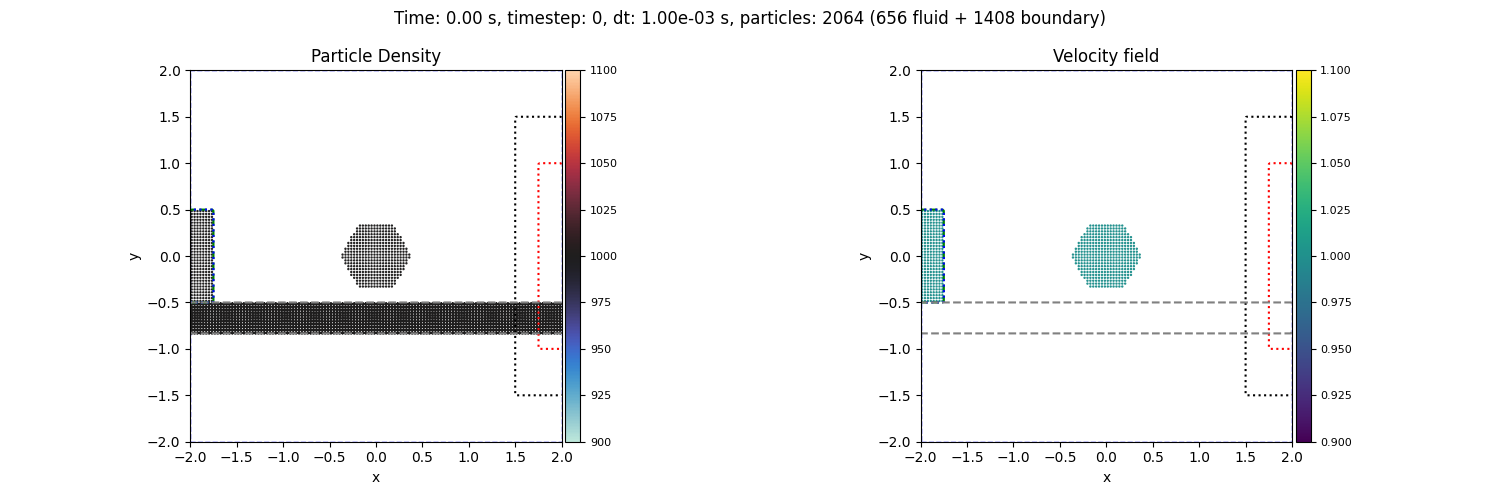

In [10]:
fig, axis = plt.subplots(1,2, figsize = (15,5), squeeze = False)
s = 0.5

visualizationState = prepVisualizationState(perennialState, config, grid = True)
plotRegions(config['regions'], axis[0,0], plotFluid=False, plotParticles=False)
plotRegions(config['regions'], axis[0,1], plotFluid=False, plotParticles=False)

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity = 'densities', mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'icefire', title = 'Particle Density', which = 'both', plotBoth = True, midPoint = 1000)
quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 'velocities', mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=False, cmap = 'viridis', streamLines = False, operation = None, title = 'Velocity field', plotBoth = False, which = 'fluid', midPoint = 1000)


# axis[0,0].scatter(
#     perennialState['boundary']['positions'][:,0].detach().cpu().numpy(), 
#     perennialState['boundary']['positions'][:,1].detach().cpu().numpy(), 
#     c = 'black',
#     marker = 'x',
#     s = 1,
#     alpha = 0.5)
# axis[0,1].scatter(
#     perennialState['boundary']['positions'][:,0].detach().cpu() .numpy(), 
#     perennialState['boundary']['positions'][:,1].detach().cpu().numpy(), 
#     c = 'black',
#     marker = 'x',
#     s = 1,
#     alpha = 0.5)


fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary)')


fig.tight_layout()

In [11]:
statistics = []

In [12]:

# from diffSPH.v2.simulationSchemes.deltaPlus import callModule
# from diffSPH.v2.modules.pressureForce import computePressureAccelSwitch
# from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne

# # from diffSPH.v2.modules.neighborhood import fluidNeighborSearch
# from diffSPH.v2.sphOps import sphOperationStates, LiuLiuConsistent
# from diffSPH.v2.util import countUniqueEntries
# from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
# from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceBarecasco
# from diffSPH.v2.math import pinv2x2, scatter_sum
# from diffSPH.v2.sphOps import sphOperation, sphOperationStates
# from diffSPH.v2.math import scatter_sum
# from diffSPH.v2.modules.densityDiffusion import renormalizedDensityGradient, computeDensityDeltaTerm, densityGradient
# from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
# from diffSPH.v2.modules.momentumEquation import computeMomentumEquation
# from diffSPH.v2.modules.viscosity import computeViscosity
# from diffSPH.v2.modules.pressureEOS import computeEOS
# from diffSPH.v2.modules.pressureForce import computePressureAccel
# from diffSPH.v2.modules.gravity import computeGravity
# from diffSPH.v2.modules.sps import computeSPSTurbulence
# from torch.profiler import record_function


# from diffSPH.v2.modules.density import computeDensity
# import torch
# from diffSPH.v2.modules.neighborhood import neighborSearch, searchNeighbors
# from diffSPH.v2.modules.normalizationMatrices import computeCovarianceMatrices
# # from diffSPH.v2.modules.inletOutlet import buildOutletGhostParticles
# from diffSPH.v2.modules.mDBC import buildBoundaryGhostParticles, mDBCDensity
# from diffSPH.v2.modules.inletOutlet import buildOutletGhostParticles

# from diffSPH.v2.modules.pressureForce import computePressureAccelSwitch
# from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne

# # from diffSPH.v2.modules.neighborhood import fluidNeighborSearch
# from diffSPH.v2.sphOps import sphOperationStates
# from diffSPH.v2.util import countUniqueEntries
# from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
# from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceBarecasco
# from diffSPH.v2.math import pinv2x2, scatter_sum
# from diffSPH.v2.sphOps import sphOperation, sphOperationStates
# from diffSPH.v2.math import scatter_sum
# from diffSPH.v2.modules.densityDiffusion import renormalizedDensityGradient, computeDensityDeltaTerm
# from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
# from diffSPH.v2.modules.momentumEquation import computeMomentumEquation
# from diffSPH.v2.modules.viscosity import computeViscosity
# from diffSPH.v2.modules.pressureEOS import computeEOS
# from diffSPH.v2.modules.pressureForce import computePressureAccel
# from diffSPH.v2.modules.gravity import computeGravity
# from diffSPH.v2.modules.sps import computeSPSTurbulence
# from torch.profiler import record_function


# from diffSPH.v2.modules.density import computeDensity
# import torch
# from diffSPH.v2.modules.neighborhood import neighborSearch
# from diffSPH.v2.modules.normalizationMatrices import computeCovarianceMatrices

In [13]:
# from diffSPH.v2.modules.inletOutlet import continuousGradient, centralDifferenceStencil
# def buildOutletGhostParticles(regions, perennialState, config):
#     ghostState = None

#     for region in regions:
#         if region['type'] != 'mirror':
#             continue
#             # ghostState = copy.deepcopy(region)
#         outletSDF = region['sdf']
#         dist = outletSDF(perennialState['fluid']['positions'])
#         mask = dist < 0
#         reducedIndices = torch.arange(perennialState['fluid']['positions'].shape[0], device = perennialState['fluid']['positions'].device, dtype =  torch.int64)[mask]

#         if mask.sum() == 0: 
#             continue

#     # axis[0,0].scatter(perennialState['fluid']['positions'][:,0].detach().cpu().numpy(), perennialState['fluid']['positions'][:,1].detach().cpu().numpy(), s = 1, c = mask)

#         i = reducedIndices
#         j = torch.arange(i.shape[0], device = i.device, dtype = i.dtype)
#         pos = perennialState['fluid']['positions'][reducedIndices]

#         dist = outletSDF(pos)

#         grad = continuousGradient(outletSDF, pos, stencil = centralDifferenceStencil(1,2), dx = config['particle']['support']*0.01, order = 1)
#         grad = grad / (torch.linalg.norm(grad, dim = 1, keepdim = True) + 1e-7)
#         ghostPos = pos - 2 * dist[:,None] * grad

#         if ghostState is None:
#             ghostState = {
#                 'positions': ghostPos,
#                 'velocities': torch.zeros_like(ghostPos),
#                 'supports': torch.ones(ghostPos.shape[0], device = ghostPos.device) * config['particle']['support'],
#                 'densities' : torch.ones(ghostPos.shape[0], device = ghostPos.device) * config['fluid']['rho0'],
#                 'masses': torch.ones(ghostPos.shape[0], device = ghostPos.device) * config['particle']['volume'] * config['fluid']['rho0'],
#                 'index': j,
#                 'fluidIndex': i,
#                 'numParticles': j.shape[0],
#                 'sdf_dist': dist,
#                 'sdf_grad': grad
#             }
#         else:
#             ghostState['positions'] = torch.cat([ghostState['positions'], ghostPos], dim = 0)
#             ghostState['velocities'] = torch.cat([ghostState['velocities'], torch.zeros_like(ghostPos)], dim = 0)
#             ghostState['supports'] = torch.cat([ghostState['supports'], torch.ones(ghostPos.shape[0], device = ghostPos.device) * config['particle']['support']], dim = 0)
#             ghostState['densities'] = torch.cat([ghostState['densities'], torch.ones(ghostPos.shape[0], device = ghostPos.device) * config['fluid']['rho0']], dim = 0)
#             ghostState['index'] = torch.cat([ghostState['index'], j], dim = 0)
#             ghostState['fluidIndex'] = torch.cat([ghostState['fluidIndex'], i], dim = 0)
#             ghostState['numParticles'] = ghostState['positions'].shape[0]
#             ghostState['sdf_dist'] = torch.cat([ghostState['sdf_dist'], dist], dim = 0)
#             ghostState['sdf_grad'] = torch.cat([ghostState['sdf_grad'], grad], dim = 0)

#     if ghostState is None:
#         return None

#     gridConfig = {
#         'domain': config['domain'],
#         'simulation': {
#             'supportScheme': 'scatter'
#         },
#         'neighborhood':{
#             'algorithm': 'compact',
#             'scheme': 'compact',
#             'verletScale': 1.0
#         },
#         'kernel': config['kernel']
#     }
#     # print('...')
#     # ghostState['neighborhood'] = neighborSearch(ghostState, perennialState['fluid'], gridConfig, computeKernels=False)
#     _, ghostState['neighborhood'] = neighborSearch(ghostState, perennialState['fluid'], gridConfig, computeKernels=True)
#     # _, ghostState['numNeighbors'] = countUniqueEntries(ghostState['neighborhood']['indices'][0], ghostState['positions'])
#     ghostState['numNeighbors'] = ghostState['neighborhood']['numNeighbors']

#     return ghostState

In [14]:


# def callModule(state, module, config, direction = 'all', reduce = 'sum', **kwargs):
#     if not config['boundary']['active']:
#         return module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs), None
#     if direction == 'all':
#         if not config['boundary']['active']:
#             return module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs), None
#         else:
#             ftf = module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs)
#             # print(f' fluid -> fluid: {ftf.shape}, mean: {ftf.mean()}, min: {ftf.min()}, max: {ftf.max()}')
#             btb = module(state['boundary'], state['boundary'], state['boundary']['neighborhood'], config, **kwargs)
#             # print(f' boundary -> boundary: {btb.shape}, mean: {btb.mean()}, min: {btb.min()}, max: {btb.max()}')
#             btf = module(state['fluid'], state['boundary'], state['boundaryToFluidNeighborhood'], config, **kwargs)
#             # print(f' boundary -> fluid: {btf.shape}, mean: {btf.mean()}, min: {btf.min()}, max: {btf.max()}')
#             ftb = module(state['boundary'], state['fluid'], state['fluidToBoundaryNeighborhood'], config, **kwargs)
#             # print(f' fluid -> boundary: {ftb.shape}, mean: {ftb.mean()}, min: {ftb.min()}, max: {ftb.max()}')

#             if reduce == 'sum':
#                 return ftf + btf, btb + ftb
#             elif reduce == 'min':
#                 return torch.min(ftf, btf), torch.min(btb, ftb)
#             elif reduce == 'max':
#                 return torch.max(ftf, btf), torch.max(btb, ftb)
#             else:
#                 raise ValueError(f"Invalid reduce {reduce}")
            
#     if direction == 'fluid':
#         return module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs), None
#     if direction == 'fluidwBoundary':
#         ftf = module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs)
#         btf = module(state['fluid'], state['boundary'], state['boundaryToFluidNeighborhood'], config, **kwargs)
#         if reduce == 'sum':
#             return ftf + btf, None
#         elif reduce == 'min':
#             return torch.min(ftf, btf), None
#         elif reduce == 'max':
#             return torch.max(ftf, btf), None
#         else:
#             raise ValueError(f"Invalid reduce {reduce}")
#     if direction == 'boundary':
#         return None, module(state['boundary'], state['boundary'], state['boundary']['neighborhood'], config, **kwargs)
#     if direction == 'boundarywFluid':
#         btb = module(state['boundary'], state['boundary'], state['boundary']['neighborhood'], config, **kwargs)
#         ftb = module(state['boundary'], state['fluid'], state['fluidToBoundaryNeighborhood'], config, **kwargs)
#         if reduce == 'sum':
#             return None, btb + ftb
#         elif reduce == 'min':
#             return None, torch.min(btb, ftb)
#         elif reduce == 'max':
#             return None, torch.max(btb, ftb)
#         else:
#             raise ValueError(f"Invalid reduce {reduce}")
#     if direction == 'fluidToBoundary':
#         return None, module(state['boundary'], state['fluid'], state['fluidToBoundaryNeighborhood'], config, **kwargs)
#     if direction == 'boundaryToFluid':
#         return module(state['fluid'], state['boundary'], state['boundaryToFluidNeighborhood'], config, **kwargs), None
#     if direction == 'oneWay':
#         ftf = module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs)
#         btf = module(state['fluid'], state['boundary'], state['boundaryToFluidNeighborhood'], config, **kwargs)
#         if reduce == 'sum':
#             return ftf + btf, None
#         elif reduce == 'min':
#             return torch.min(ftf, btf), None
#         elif reduce == 'max':
#             return torch.max(ftf, btf), None
#         else:
#             raise ValueError(f"Invalid reduce {reduce}")
#     raise ValueError(f"Invalid direction {direction}")



# def checkNaNs(state):
#     for key in state:
#         if isinstance(state[key], torch.Tensor):
#             if torch.any(torch.isnan(state[key])):
#                 print(f'NaNs in {key}')
#                 raise RuntimeError(f'NaNs in {key}')
#         if not isinstance(state[key], dict):
#             continue
#         for subkey in state[key]:
#             if not isinstance(state[key][subkey], torch.Tensor):
#                 continue
#             if torch.any(torch.isnan(state[key][subkey])):
#                 print(f'NaNs in {key} - {subkey}')
#                 raise RuntimeError(f'NaNs in {key} - {subkey}')
# def checkNaN(tensor, name):
#     if torch.any(torch.isnan(tensor)):
#         print(f'NaNs in {name}, number of NaNs: {torch.sum(torch.isnan(tensor))}')
#         raise RuntimeError(f'NaNs in {name}, number of NaNs: {torch.sum(torch.isnan(tensor))}')

# def simulationStep(state, config):
#     if config['compute']['checkNaN']:
#         checkNaNs(state)


#     with record_function("[SPH] - deltaSPH (1 - Neighbor Search)"):
#         searchNeighbors(state, config)
#         # torch.cuda.synchronize()

#     with record_function("[SPH] - deltaSPH (2 - Ghost Particle Creation)"):
#         if config['boundary']['active'] and 'boundary' in state:
#             state['boundaryGhost'] = buildBoundaryGhostParticles(state, config)
#         if 'regions' in  config and config['regions'] is not None:
#             state['outletGhost'] = buildOutletGhostParticles(config['regions'], state, config)
#         # torch.cuda.synchronize()
        
#     with record_function("[SPH] - deltaSPH (3 - Density Computation)"):
#         if config['simulation']['densityScheme'] == 'summation':
#             if config['boundary']['active']:
#                 state['fluid']['densities'], state['boundary']['densities'] = callModule(state, computeDensity, config, 'all')
#             else:
#                 state['fluid']['densities'], _ = callModule(state, computeDensity, config, 'fluid')
#             torch.cuda.synchronize()
#         # print(f'Density Min: {state["fluid"]["densities"].min()}, Max: {state["fluid"]["densities"].max()}')
#         if config['boundary']['active']:
#             with record_function("[SPH] - deltaSPH (3 - mDBC Density Estimate)"):
#                 state['boundary']['densities'], state['boundaryGhost']['densities'] = mDBCDensity(state, config)
#                 # state['boundary']['densities'] += torch.abs(state['boundary']['distances']) / config['particle']['support'] * 2
#                 # torch.cuda.synchronize()
#         if config['compute']['checkNaN']:
#             checkNaN(state['fluid']['densities'], 'densities')
#         if config['boundary']['active']:
#             if config['compute']['checkNaN']:
#                 checkNaN(state['boundary']['densities'], 'boundary - densities')
#     if 'regions' in config and config['regions'] is not None:
#         if state['outletGhost'] is not None:
#             with record_function("[SPH] - deltaSPH (4 - Outlet Processing)"):
#                 ghostState = state['outletGhost']
#                 neighbors = ghostState['neighborhood']['indices'][0]
#                 solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['densities'])

#                 cond = torch.logical_and(ghostState['numNeighbors'] >= 1, ghostState['sdf_dist'] < 2.5 * config['particle']['support'])
#                 cond = ghostState['numNeighbors'] >= 10

#                 def updateQuantity(state, ghostState, quantity, solution, cond):
#                     return torch.where(cond, solution[:,0] + torch.einsum('nd, nd -> n', ghostState['sdf_dist'][:,None] * ghostState['sdf_grad'] * 2, solution[:,1:]), quantity)
#                 state['fluid']['densities'][ghostState['fluidIndex']] = updateQuantity(state, ghostState, state['fluid']['densities'][ghostState['fluidIndex']], solution, cond)
#                 state['fluid']['outletMarker'] = state['fluid']['densities'].new_zeros(state['fluid']['densities'].shape[0])
#                 state['fluid']['outletMarker'][ghostState['fluidIndex']] = 1

#                 solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['velocities'][:,0])
#                 state['fluid']['velocities'][ghostState['fluidIndex'],0] = updateQuantity(state, ghostState, state['fluid']['velocities'][ghostState['fluidIndex']][:,0], solution, cond)

                
#                 solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['velocities'][:,1])
#                 state['fluid']['velocities'][ghostState['fluidIndex'],1] =updateQuantity(state, ghostState, state['fluid']['velocities'][ghostState['fluidIndex']][:,1], solution, cond)

#                 if config['compute']['checkNaN']:
#                     checkNaN(state['fluid']['densities'], 'densities')
#                     checkNaN(state['fluid']['velocities'], 'velocities')
                

#                 # torch.cuda.synchronize()

#     with record_function("[SPH] - deltaSPH (5 - Normalization Matrices)"):
#         # state['fluid']['covarianceMatrix'], _ = callModule(state, computeCovarianceMatrices, config, 'fluidwBoundary')
#         state['fluid']['covarianceMatrix'], _ = callModule(state, computeCovarianceMatrices, config, 'fluid')
#         if config['compute']['checkNaN']:
#             checkNaN(state['fluid']['covarianceMatrix'], 'covarianceMatrix')
#         state['fluid']['covarianceMatrix'][state['fluid']['numNeighbors'] < 4,:,:] = torch.eye(2, dtype = state['fluid']['covarianceMatrix'].dtype, device = state['fluid']['covarianceMatrix'].device)[None,:,:]


#         state['fluid']['L'], state['fluid']['L.EVs'] = pinv2x2(state['fluid']['covarianceMatrix'])

#         if config['compute']['checkNaN']:
#             checkNaN(state['fluid']['L'], 'L')
#             checkNaN(state['fluid']['L.EVs'], 'L.EVs')

#         # torch.cuda.synchronize()

#     with record_function("[SPH] - deltaSPH (6 - Density Gradient)"):
#         state['fluid']['gradRho^L'],_ = callModule(state, renormalizedDensityGradient, config, 'fluid')
#         if config['compute']['checkNaN']:
#             checkNaN(state['fluid']['gradRho^L'], 'gradRho^L')

#         # if config['boundary']['active']:
#             # state['fluid']['gradRho^L'] += callModule(state, densityGradient, config, 'boundaryToFluid')[0]


#         # state['boundary']['gradRho^L'] = callModule(state, densityGradient, config, 'boundary')[1]
#         # torch.cuda.synchronize()

#     with record_function("[SPH] - deltaSPH (7 - Diffusion and Momentum)"):
#         state['fluid']['densityDiffusion'], _ = callModule(state, computeDensityDeltaTerm, config, 'fluid')
#         if config['compute']['checkNaN']:
#             checkNaN(state['fluid']['densityDiffusion'], 'densityDiffusion')
#         # state['fluid']['densityDiffusion'] += callModule(state, computeDensityDeltaTerm, config, 'boundaryToFluid')[0]

#         # state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')
#         # torch.cuda.synchronize()
#         if config['boundary']['active']:
#             # state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')
#             state['fluid']['velocityDiffusion'], state['boundary']['velocityDiffusion'] = callModule(state, computeViscosity, config, 'all')
#             if config['compute']['checkNaN']:
#                 checkNaN(state['fluid']['velocityDiffusion'], 'velocityDiffusion')
#                 checkNaN(state['boundary']['velocityDiffusion'], 'boundary - velocityDiffusion')

#             state['fluid']['momentumEquation'], state['boundary']['momentumEquation'] = callModule(state, computeMomentumEquation, config, 'all')
#             if config['compute']['checkNaN']:
#                 checkNaN(state['fluid']['momentumEquation'], 'momentumEquation')
#                 checkNaN(state['boundary']['momentumEquation'], 'boundary - momentumEquation')
#         else:
#             state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')
#             if config['compute']['checkNaN']:
#                 checkNaN(state['fluid']['velocityDiffusion'], 'velocityDiffusion')

#             state['fluid']['momentumEquation'], _ = callModule(state, computeMomentumEquation, config, 'fluid')
#             if config['compute']['checkNaN']:
#                 checkNaN(state['fluid']['momentumEquation'], 'momentumEquation')
#         # torch.cuda.synchronize()
#         state['fluid']['pressures'] = computeEOS(state['fluid'], config)
#         if config['compute']['checkNaN']:
#                 checkNaN(state['fluid']['pressures'], 'pressures')

#         if 'boundary' in state:
#             state['boundary']['pressures'] = computeEOS(state['boundary'], config)
#             if config['compute']['checkNaN']:
#                 checkNaN(state['boundary']['pressures'], 'boundary - pressures')

#     with record_function("[SPH] - deltaSPH (8 - Pressure Forces)"):
#         if 'boundary' in state:
#             state['fluid']['pressureAccel'], state['boundary']['pressureAccel'] = callModule(state, computePressureAccel, config, 'all')
#             if config['compute']['checkNaN']:
#                 # print(f'Pressure Min: {state["fluid"]["pressureAccel"].min()}, Max: {state["fluid"]["pressureAccel"].max()}')
#                 # print(f'Density Min: {state["fluid"]["densities"].min()}, Max: {state["fluid"]["densities"].max()}')
#                 # if 'outletMarker' in state['fluid']:
#                 #     print('In Mask:')
#                 #     print(f'Pressure Min: {state["fluid"]["pressureAccel"][state["fluid"]["outletMarker"] == 1].min()}, Max: {state["fluid"]["pressureAccel"][state["fluid"]["outletMarker"] == 1].max()}')
#                 #     print(f'Density Min: {state["fluid"]["densities"][state["fluid"]["outletMarker"] == 1].min()}, Max: {state["fluid"]["densities"][state["fluid"]["outletMarker"]== 1].max()}')

#                 #     print('Out Mask:')
#                 #     print(f'Pressure Min: {state["fluid"]["pressureAccel"][state["fluid"]["outletMarker"] == 0].min()}, Max: {state["fluid"]["pressureAccel"][state["fluid"]["outletMarker"] == 0].max()}')
#                 #     print(f'Density Min: {state["fluid"]["densities"][state["fluid"]["outletMarker"] == 0].min()}, Max: {state["fluid"]["densities"][state["fluid"]["outletMarker"] == 0].max()}')


#                 checkNaN(state['fluid']['pressureAccel'], 'pressureAccel')
#                 checkNaN(state['boundary']['pressureAccel'], 'boundary - pressureAccel')
#         else:
#             state['fluid']['pressureAccel'], _ = callModule(state, computePressureAccel, config, 'fluid')
#             checkNaN(state['fluid']['pressureAccel'], 'pressureAccel')
#         # torch.cuda.synchronize()
#     # state['fluid']['divergence'], state['boundary']['divergence'] = callModule(state, computePressureAccel, config, 'all')

#     with record_function("[SPH] - deltaSPH (9 - External Forcing)"):
#         state['fluid']['gravityAccel'] = computeGravity(state['fluid'], config)
#         if config['compute']['checkNaN']:
#             checkNaN(state['fluid']['gravityAccel'], 'gravityAccel')
#         # torch.cuda.synchronize()

#     # if config['SPS']['active']:
#     #     with record_function("[SPH] - deltaSPH (7 - SPS Turbulence)"):
#     #         state['fluid']['fluidSPSTurbulence'] = computeSPSTurbulence(simulationState, config)
#     # torch.cuda.synchronize()

#     with record_function("[SPH] - deltaSPH (10 - Integration)"):
#         dudt = state['fluid']['pressureAccel'] + state['fluid']['gravityAccel'] + state['fluid']['velocityDiffusion']
#         drhodt = state['fluid']['momentumEquation'] + state['fluid']['densityDiffusion']
#         if config['compute']['checkNaN']:
#             checkNaN(dudt, 'dudt')
#             checkNaN(drhodt, 'drhodt')
        

#         if 'regions' in config and  config['regions'] is not None:
#             if state['outletGhost'] is not None:
#                 dudt[ghostState['fluidIndex'],:] = 0
#                 drhodt[ghostState['fluidIndex']] = 0

                    
#                 # bi = torch.unique(state['boundaryToFluidNeighborhood']['indices'][0])
#                 # oi = state['outletGhost']['fluidIndex']

#                 # hasBoundaryNeighbors = torch.zeros(state['fluid']['numParticles'], dtype = torch.bool, device = state['fluid']['positions'].device)
#                 # hasBoundaryNeighbors[bi] = True

#                 # hasOutletNeighbors = torch.zeros(state['fluid']['numParticles'], dtype = torch.bool, device = state['fluid']['positions'].device)
#                 # hasOutletNeighbors[oi] = True

#                 # mask = torch.logical_and(hasOutletNeighbors, hasBoundaryNeighbors)
#                 # indices = torch.arange(state['fluid']['numParticles'], device = state['fluid']['positions'].device)[mask]

#                 # # print(indices)

#                 # projectedVelocities = state['fluid']['velocities'].clone()
#                 # normal = torch.Tensor([0.,1.]).to(projectedVelocities.device)
#                 # projectedVelocities[indices] = projectedVelocities[indices] - torch.einsum('n, d -> nd', torch.einsum('nd, d -> n', state['fluid']['velocities'][indices], normal), normal)

#                 # dudt_ = -(projectedVelocities - state['fluid']['velocities']) / state['timestep']
#                 # dudt[indices] = dudt_[indices]
#                 # # state['fluid']['velocities'][indices] = projectedVelocities[indices] - torch.einsum('n, d -> nd', torch.einsum('nd, d -> n', state['fluid']['velocities'][indices], normal), normal)



#         if 'boundary' not in state:
#             return (state['fluid']['velocities'].clone(), dudt, drhodt), (None, None, None)
#         # torch.cuda.synchronize()   
#         boundary_dudt = state['boundary']['pressureAccel'] #+ state['boundary']['velocityDiffusion']
#         boundary_drhodt = state['boundary']['momentumEquation'] *0

#         return (state['fluid']['velocities'].clone(), dudt, drhodt), (state['boundary']['velocities'].clone(), None, boundary_drhodt)
# # from diffSPH.parameter import Parameter
# # def getParameters():
# #     return [
# #         Parameter('deltaSPH', 'pressureSwitch', bool, False, required = False, export = True, hint = 'Switches the pressure force calculation to the Antuono Correction'),
# #     ]


# from torch.profiler import profile, record_function, ProfilerActivity


In [15]:
from diffSPH.v2.plotting import exportPlot, postProcessPlot
from diffSPH.v2.simulationSchemes.deltaPlus import checkNaN
from diffSPH.v2.modules.inletOutlet import processInlet, processOutlet, processForcing

priorState = None
for i in tqdm(range(3300)):
    if 'shiftAmount' in perennialState['fluid']:
        del perennialState['fluid']['shiftAmount']
    perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
    dx, _ = solveShifting(perennialState, config)
    numNeighbors = perennialState['fluid']['neighborhood']['numNeighbors']
    perennialState['fluid']['shiftAmount'] = dx

    mask = numNeighbors > 5
    if 'regions' in config and config['regions'] is not None:
        for emitter in config['regions']:
            if emitter['type'] != 'mirror':
                continue

            outletSDF = emitter['sdf']
            dist = outletSDF(perennialState['fluid']['positions'])
            mask = torch.logical_and(dist >= 0, mask)
            
        # print('Masking with outlet marker')
        # mask = torch.logical_and(mask, perennialState['fluid']['outletMarker'] == 0)


    perennialState['fluid']['positions'][mask] += dx[mask]
    if config['compute']['checkNaN']:
        checkNaN(perennialState['fluid']['positions'], 'positions')
        checkNaN(perennialState['fluid']['shiftAmount'], 'shiftAmount')
    
    # perennialState = simulationStep(perennialState, config)
    # perennialState['fluidGhostParticles'] = buildOutletGhostParticles(regions, perennialState, config)


    perennialState['time'] += config['timestep']['dt']
    perennialState['timestep'] += 1
    fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary)')
    # perennialState['fluid']['positions'] += perennialState['fluid']['velocities'] * config['timestep']['dt']

    statistics.append(computeStatistics(perennialState, particleState, config))
    if i % 30 == 0:
        # printState(perennialState)
        # print(f'Iteration {i}')
        visualizationState = prepVisualizationState(perennialState, config)
        updatePlot(indexPlot, visualizationState, 'densities')
        updatePlot(quantPlot, visualizationState, 'velocities')
        fig.canvas.draw()
        fig.canvas.flush_events()
        exportPlot(perennialState, config, fig)
    if 'regions' in config and config['regions'] is not None:
        for emitter in config['regions']:
            if emitter['type'] == 'inlet':
                processInlet(perennialState, config, emitter)
            if emitter['type'] == 'outlet':
                processOutlet(emitter, config, perennialState)
            if emitter['type'] == 'forcing':
                processForcing(emitter, config, perennialState)


  0%|          | 0/3300 [00:00<?, ?it/s]

In [51]:
config["plot"]["gifScale"] = 1280

In [16]:

import subprocess
import shlex

outFile = config['plot']['namingScheme'] if config['plot']['namingScheme'] != 'timestep' else config["simulation"]["timestamp"]
if config['plot']['namingScheme'] == 'timestep':
    outFolder = f'{config["plot"]["exportPath"]}/{config["simulation"]["timestamp"]}/'
else:
    outFolder = f'{config["plot"]["exportPath"]}/{config["plot"]["namingScheme"]}/'

os.makedirs(outFolder, exist_ok = True)
# print('Creating video from  frames (frame count: {})'.format(len(os.listdir(outFolder))))
command = '/usr/bin/ffmpeg -loglevel warning -y -framerate 30 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -b:v 20M -r ' + str(config['plot']['exportFPS']) + ' ' + outFolder + 'output.mp4'
commandB = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -vf "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos,palettegen" output/palette.png'
commandC = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -i output/palette.png -filter_complex "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos[x];[x][1:v]paletteuse" {outFile}.gif'

subprocess.run(shlex.split(command))
subprocess.run(shlex.split(commandB))
subprocess.run(shlex.split(commandC))

[Parsed_palettegen_2 @ 0x5d0118f79440] Dupped color: FFFCFCFC
[Parsed_palettegen_2 @ 0x5d0118f79440] Dupped color: FFFDFFFE
[Parsed_palettegen_2 @ 0x5d0118f79440] Dupped color: FFFEFFFD
    Last message repeated 1 times


CompletedProcess(args=['ffmpeg', '-loglevel', 'warning', '-hide_banner', '-y', '-i', 'output/2024_06_14-11_15_26/output.mp4', '-i', 'output/palette.png', '-filter_complex', 'fps=30,scale=640:-1:flags=lanczos[x];[x][1:v]paletteuse', '2024_06_14-11_15_26.gif'], returncode=0)

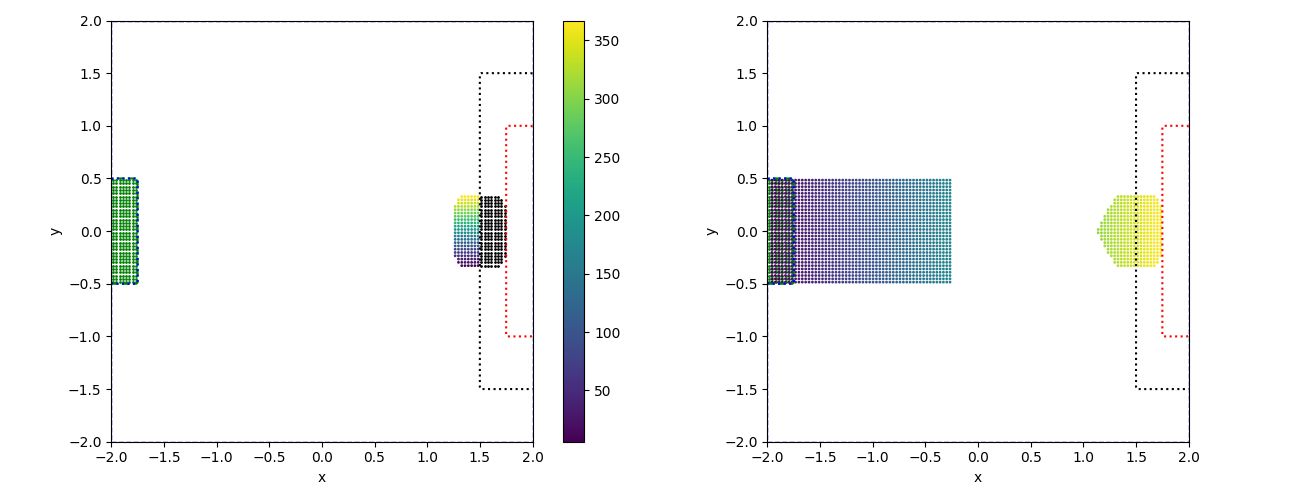

In [ ]:
from diffSPH.v2.plotting import setPlotBaseAttributes

fig, axis = plt.subplots(1, 2, figsize = (13,5), squeeze = False)

setPlotBaseAttributes(axis[0,0], config)
setPlotBaseAttributes(axis[0,1], config)

plotRegions(regions, axis[0,0])
plotRegions(regions, axis[0,1])
fig.tight_layout()


ghostState = buildOutletGhostParticles(regions, perennialState, config)

if ghostState is not None:

    sc = axis[0,0].scatter(ghostState['positions'][:,0].detach().cpu().numpy(), ghostState['positions'][:,1].detach().cpu().numpy(), s = 1, c = ghostState['fluidIndex'])
    fig.colorbar(sc, ax = axis[0,0])

    ghostPos = perennialState['fluid']['positions'][ghostState['fluidIndex']]

    # axis[0,0].quiver(pos[:,0].detach().cpu().numpy(), pos[:,1].detach().cpu().numpy(), grad[:,0].detach().cpu().numpy(), grad[:,1].detach().cpu().numpy(), color = 'black', scale = 10)

    sc = axis[0,0].scatter(ghostPos[:,0].detach().cpu().numpy(), ghostPos[:,1].detach().cpu().numpy(), s = 1, c = 'black')

q = perennialState['fluid']['positions'][:,0]# * perennialState['fluid']['positions'][:,1]


sc = axis[0,1].scatter(perennialState['fluid']['positions'][:,0].detach().cpu().numpy(), perennialState['fluid']['positions'][:,1].detach().cpu().numpy(), s = 1, c = q)


In [ ]:
# qfn = lambda x: x[:,0] + x[:,1]

# q = qfn(fluidState['positions'])# + fluidState['positions'][:,1]
# solution, M, b = LiuLiuConsistent(ghostState, fluidState, q)
# print(f'solution: {solution.shape}, min: {solution.min()}, max: {solution.max()}')

# extrapolated = solution[:,0] + torch.einsum('nd, nd -> n', ghostState['sdf_dist'][:,None] * ghostState['sdf_grad'] * 2, solution[:,1:])
# print(f'extrapolated: {extrapolated.shape}, min: {extrapolated.min()}, max: {extrapolated.max()}')

# ghostPos = perennialState['fluid']['positions'][ghostState['fluidIndex']]
# gt = qfn(ghostPos)

# error = extrapolated - gt
# print(f'error: {error.shape}, min: {error.min()}, max: {error.max()}, mean: {error.mean()}')


solution: torch.Size([168, 3]), min: 0.9999753832817078, max: 1.8124845027923584
extrapolated: torch.Size([168]), min: 1.1875139474868774, max: 2.0000178813934326
error: torch.Size([168]), min: -5.4836273193359375e-06, max: 3.2186508178710938e-06, mean: 2.0790668031622772e-07


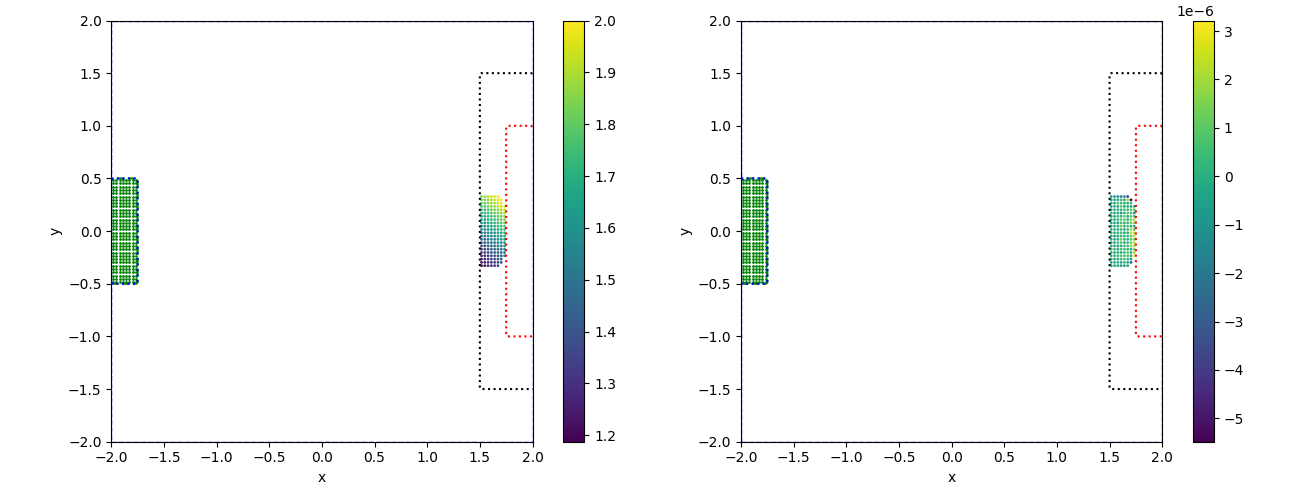

In [ ]:
from diffSPH.v2.plotting import setPlotBaseAttributes

qfn = lambda x: x[:,0] + x[:,1]

q = qfn(fluidState['positions'])# + fluidState['positions'][:,1]
if ghostState is not None:
    solution, M, b = LiuLiuConsistent(ghostState, fluidState, q)
    print(f'solution: {solution.shape}, min: {solution.min()}, max: {solution.max()}')

    extrapolated = solution[:,0] + torch.einsum('nd, nd -> n', ghostState['sdf_dist'][:,None] * ghostState['sdf_grad'] * 2, solution[:,1:])
    print(f'extrapolated: {extrapolated.shape}, min: {extrapolated.min()}, max: {extrapolated.max()}')

    ghostPos = perennialState['fluid']['positions'][ghostState['fluidIndex']]
    gt = qfn(ghostPos)

    error = extrapolated - gt
    print(f'error: {error.shape}, min: {error.min()}, max: {error.max()}, mean: {error.mean()}')


fig, axis = plt.subplots(1, 2, figsize = (13,5), squeeze = False)

setPlotBaseAttributes(axis[0,0], config)
setPlotBaseAttributes(axis[0,1], config)

plotRegions(regions, axis[0,0])
plotRegions(regions, axis[0,1])
fig.tight_layout()


ghostState = buildOutletGhostParticles(regions, perennialState, config)

if ghostState is not None:

    # sc = axis[0,0].scatter(ghostState['positions'][:,0].detach().cpu().numpy(), ghostState['positions'][:,1].detach().cpu().numpy(), s = 1, c = b[:,0])
    # fig.colorbar(sc, ax = axis[0,0])

    # ghostPos = perennialState['fluid']['positions'][ghostState['fluidIndex']]

    # axis[0,0].quiver(pos[:,0].detach().cpu().numpy(), pos[:,1].detach().cpu().numpy(), grad[:,0].detach().cpu().numpy(), grad[:,1].detach().cpu().numpy(), color = 'black', scale = 10)

    sc = axis[0,0].scatter(ghostPos[:,0].detach().cpu().numpy(), ghostPos[:,1].detach().cpu().numpy(), s = 1, c = extrapolated)
    fig.colorbar(sc, ax = axis[0,0])

    q = perennialState['fluid']['positions'][:,0]# * perennialState['fluid']['positions'][:,1]


    sc = axis[0,1].scatter(ghostPos[:,0].detach().cpu().numpy(), ghostPos[:,1].detach().cpu().numpy(), s = 1, c = extrapolated - gt)
    fig.colorbar(sc, ax = axis[0,1])
# sc = axis[0,1].scatter(perennialState['fluid']['positions'][:,0].detach().cpu().numpy(), perennialState['fluid']['positions'][:,1].detach().cpu().numpy(), s = 1, c = q)


In [ ]:

for i in tqdm(range(1500)):
    # perennialState = simulationStep(perennialState, config)
    perennialState['fluidGhostParticles'] = buildOutletGhostParticles(regions, perennialState, config)


    perennialState['time'] += config['timestep']['dt']
    perennialState['fluid']['positions'] += perennialState['fluid']['velocities'] * config['timestep']['dt']

    if i % 50 == 0:
        # printState(perennialState)
        # print(f'Iteration {i}')
        visualizationState = prepVisualizationState(perennialState, config)
        updatePlot(indexPlot, visualizationState, 'index')
        updatePlot(quantPlot, visualizationState, 'velocities')
        fig.canvas.draw()
        fig.canvas.flush_events()

    for emitter in regions:
        if emitter['type'] == 'inlet':
            processInlet(perennialState, emitter)
        if emitter['type'] == 'outlet':
            processOutlet(emitter, config, perennialState)

    # emitterNeighborhood = neighborSearch(emitterPositions, perennialState['fluid'], config, computeKernels=False)

    # distance = emitterNeighborhood['distances']
    # i = emitterNeighborhood['indices'][0]
    # newDistance = distance.new_ones(emitterPositions['numParticles'], dtype = config['compute']['dtype']) #* config['particle']['support']
    # minDistance = newDistance.index_reduce_(dim = 0, index = i, source = distance, include_self = False, reduce = 'amin')

    # emitterMask = minDistance >= config['particle']['dx'] / config['particle']['support']

    # newPositions = emitterPositions['positions'][emitterMask].to(config['compute']['device'])
    # newParticleState = {
    #     'numParticles': newPositions.shape[0],
    #     'positions': newPositions,

    #     'areas': torch.ones(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']) * config['particle']['volume'],
    #     'masses': torch.ones(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']) * config['particle']['volume'] * config['fluid']['rho0'],
    #     'densities': torch.ones(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']) * config['fluid']['rho0'],
    #     'supports': torch.ones(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']) * config['particle']['support'],

    #     'pressures': torch.zeros(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']),
    #     'divergence': torch.zeros(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']),

    #     'velocities': torch.zeros(newPositions.shape, dtype = config['compute']['dtype'], device = config['compute']['device']),
    #     'accelerations': torch.zeros(newPositions.shape, dtype = config['compute']['dtype'], device = config['compute']['device']),
    #     'index': torch.arange(newPositions.shape[0], dtype = torch.int32, device = config['compute']['device']) + perennialState['uidCounter'],
    #     # 'neighbors': None,
    # }
    # newParticleState['velocities'][:,0] = u
    # # print(f'Adding {newParticleState["numParticles"]} particles (total {perennialState["fluid"]["numParticles"] + newParticleState["numParticles"]})')
    # perennialState['uidCounter'] += newParticleState['numParticles']

    # perennialState['fluid'] = mergeStates(perennialState['fluid'], newParticleState)


# visualizationState = prepVisualizationState(perennialState, config)
# updatePlot(indexPlot, visualizationState, 'index')
# updatePlot(quantPlot, visualizationState, 'densities')

  0%|          | 0/1500 [00:00<?, ?it/s]

Outlet: 2 particles removed
Current particles: 2032
torch.Size([2030]) tensor([   0,    1,    2,  ..., 2029, 2030, 2031])
Outlet: 6 particles removed
Current particles: 2062
torch.Size([2056]) tensor([   0,    1,    2,  ..., 2059, 2060, 2061])
Outlet: 10 particles removed
Current particles: 2088
torch.Size([2078]) tensor([   0,    1,    2,  ..., 2085, 2086, 2087])
Outlet: 14 particles removed
Current particles: 2110
torch.Size([2096]) tensor([   0,    1,    2,  ..., 2107, 2108, 2109])


In [ ]:
emitterPositions

{'numParticles': 1560,
 'positions': tensor([[-0.1953, -0.3203],
         [-0.1797, -0.3203],
         [-0.1641, -0.3203],
         ...,
         [ 0.1641,  0.3203],
         [ 0.1797,  0.3203],
         [ 0.1953,  0.3203]], device='cuda:0'),
 'areas': tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002], device='cuda:0'),
 'pressures': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 'divergence': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 'masses': tensor([0.2441, 0.2441, 0.2441,  ..., 0.2441, 0.2441, 0.2441], device='cuda:0'),
 'supports': tensor([0.0593, 0.0593, 0.0593,  ..., 0.0593, 0.0593, 0.0593], device='cuda:0'),
 'index': tensor([   0,    1,    2,  ..., 1557, 1558, 1559], device='cuda:0'),
 'densities': tensor([1000., 1000., 1000.,  ..., 1000., 1000., 1000.], device='cuda:0'),
 'velocities': tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]], device='cuda:0'),
 'accele

In [ ]:
config['particle']

{'nx': 128,
 'dx': tensor(0.0156, device='cuda:0'),
 'support': tensor(0.0593, device='cuda:0'),
 'defaultVolume': tensor(0.0002, device='cuda:0'),
 'defaultSupport': tensor(0.0593, device='cuda:0'),
 'volume': tensor(0.0002, device='cuda:0'),
 'smoothingLength': tensor(0.0312, device='cuda:0')}

1560 1434


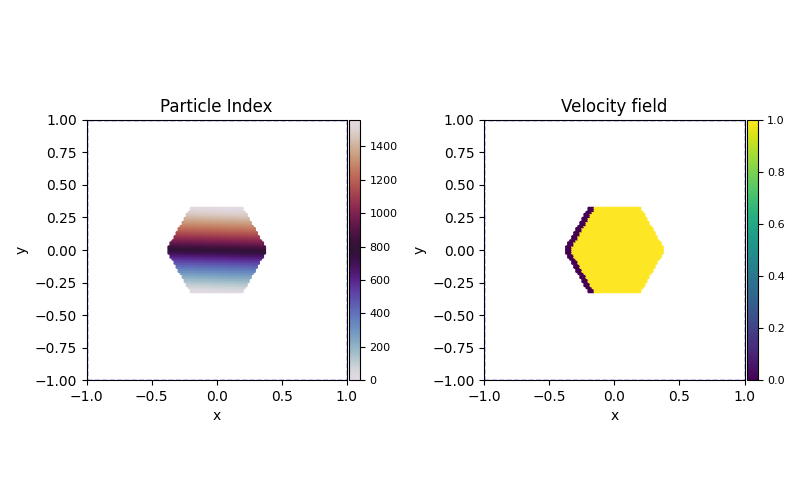

In [ ]:
fig, axis = plt.subplots(1,2, figsize = (8,5), squeeze = False)

s = 2
emitterState = {
    'fluid': copy.deepcopy(emitterPositions),
    'time': 0.0,
    'timestep': 0,
    'dt': config['timestep']['dt'],
}

u = 1
perennialState['fluid']['velocities'][:,0] = u

visualizationState = prepVisualizationState(emitterState, config)

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity = 'index', mapping = '.x', s = s, 
                          scaling = 'lin', gridVisualization=False, cmap = 'twilight', title = 'Particle Index')
quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = emitterMask, mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=False, cmap = 'viridis', streamLines = False, operation = None, title = 'Velocity field')

fig.tight_layout()

{'numParticles': 7296,
 'positions': tensor([[-0.1453, -0.3203],
         [-0.1297, -0.3203],
         [-0.1141, -0.3203],
         ...,
         [ 0.1641,  0.3203],
         [ 0.1797,  0.3203],
         [ 0.1953,  0.3203]], device='cuda:0'),
 'areas': tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002], device='cuda:0'),
 'pressures': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 'divergence': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 'masses': tensor([0.2441, 0.2441, 0.2441,  ..., 0.2441, 0.2441, 0.2441], device='cuda:0'),
 'supports': tensor([0.0593, 0.0593, 0.0593,  ..., 0.0593, 0.0593, 0.0593], device='cuda:0'),
 'index': tensor([   0,    1,    2,  ..., 1431, 1432, 1433], device='cuda:0'),
 'densities': tensor([1000., 1000., 1000.,  ..., 1000., 1000., 1000.], device='cuda:0'),
 'velocities': tensor([[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]], device='cuda:0'),
 'accele

In [ ]:
emitterPositions

{'numParticles': 1560,
 'positions': tensor([[-0.1953, -0.3203],
         [-0.1797, -0.3203],
         [-0.1641, -0.3203],
         ...,
         [ 0.1641,  0.3203],
         [ 0.1797,  0.3203],
         [ 0.1953,  0.3203]], device='cuda:0'),
 'areas': tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002], device='cuda:0'),
 'pressures': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 'divergence': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 'masses': tensor([0.2441, 0.2441, 0.2441,  ..., 0.2441, 0.2441, 0.2441], device='cuda:0'),
 'supports': tensor([0.0593, 0.0593, 0.0593,  ..., 0.0593, 0.0593, 0.0593], device='cuda:0'),
 'index': tensor([   0,    1,    2,  ..., 1557, 1558, 1559], device='cuda:0'),
 'densities': tensor([1000., 1000., 1000.,  ..., 1000., 1000., 1000.], device='cuda:0'),
 'velocities': tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]], device='cuda:0'),
 'accele

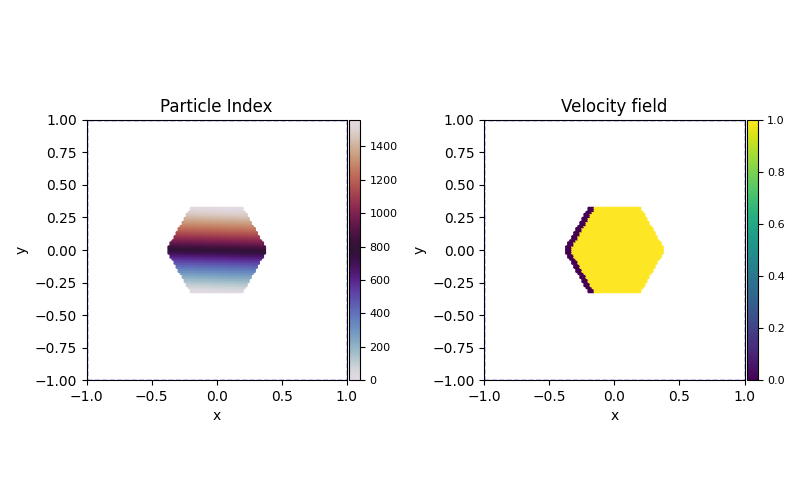

In [ ]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict

particleState, mask = sampleParticles(config, sdfs = [sdf])

priorState = None
# particleState['velocities'][:,0] =  u_mag * torch.cos(k * particleState['positions'][:,0]) * torch.sin(k * particleState['positions'][:,1])
# particleState['velocities'][:,1] = -u_mag * torch.sin(k * particleState['positions'][:,0]) * torch.cos(k * particleState['positions'][:,1])
particleState['velocities'][:,0] =  1 
particleState['velocities'][:,1] = 0

u_max = torch.linalg.norm(particleState['velocities'], dim = 1).max()
# particleState['velocities'] = particleState['velocities'] / (u_max + 1e-7) * u_mag
Ek0 = 0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(particleState['velocities'], dim = -1)**2

initialVelocities = particleState['velocities'].clone()

particleState['Eks'] =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2)
particleState['E_k'] = particleState['Eks'].sum().cpu().detach().item()

# perennialState = {
#     'fluid': copy.deepcopy(particleState),
#     'time': 0.0,
#     'timestep': 0,
#     'dt': config['timestep']['dt'],
# }
# del particleState['neighborhood']


In [ ]:
# from diffSPH.v2.plotting import computePSD, plotFFT, plotPSD, mapToGrid, visualizeParticleQuantity

# s = 2

# fig, axis = plt.subplot_mosaic('''AB''', figsize=(10.5,5), sharex = False, sharey = False)

# visualizationState = prepVisualizationState(perennialState, config)

# visualizeParticleQuantity(fig, axis['A'], config, visualizationState, quantity = 'index', mapping = '.x', s = s, 
#                           scaling = 'lin', gridVisualization=False, cmap = 'twilight', title = 'Particle Index')
# visualizeParticleQuantity(fig, axis['B'], config, visualizationState, quantity = 'velocities', mapping = 'L2', s = s, 
#                           scaling = 'sym', gridVisualization=True, cmap = 'icefire', streamLines = True, operation = None, title = 'Velocity field')

# E_k0 =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2).sum().detach().cpu().numpy()
# E_k = (0.5 * torch.sum(perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = 1)**2)).sum().detach().cpu().numpy()
# nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
# Re = u_mag * 2 / nu_total

# fig.suptitle(f'Taylor-Green Vortex (TGV), $Re = {targetRe}$, particles = {nx}x{nx} = {nx**2}\n $t = {perennialState["time"]:.2f}$, $\Delta t = {perennialState["dt"]:.3e}$, $k = {k/np.pi}$, $u_0 = {u_mag}$, $L = {L}$, $E_k^0 = {Ek0.sum():.2f}$/$E_k = {particleState["E_k"]:.2f}$ -> Re = {Re}')

# fig.tight_layout()

In [ ]:
# torch.cuda.memory._record_memory_history(max_entries=100000)

Setting up initial plot
Computing visualization state
Setting up plot A
Setting up plot B
Done setting up initial plot


0.0000%|          | 0/1 [00:00<?] ?it/s

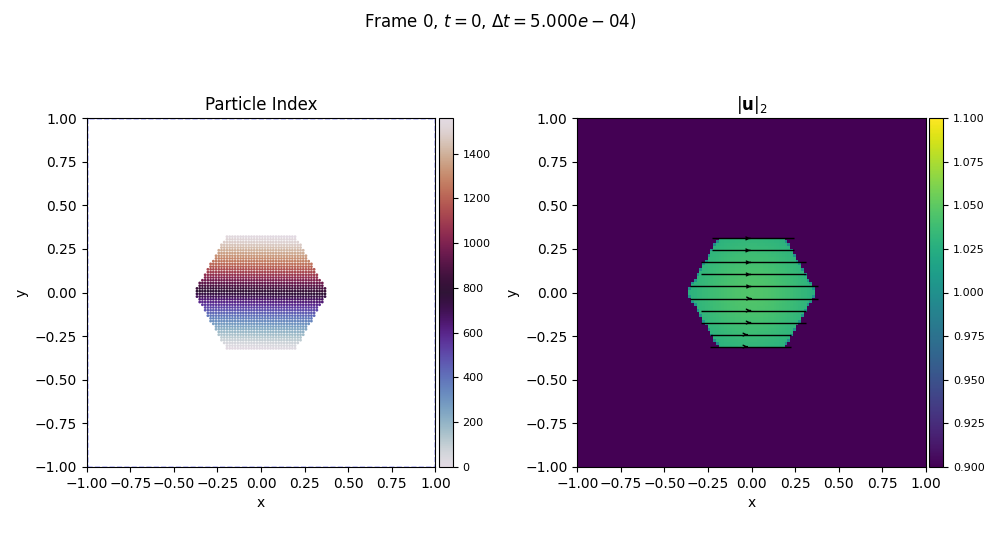

In [ ]:
from diffSPH.v2.plotting import updatePlots
from diffSPH.v2.runner import runSimulation, setupSimulation

def callBackFn(perennialState, particleState, config, plotStates, fig, axis, frameStatistics):
    pass
    # E_k = perennialState['fluid']['E_k']
    # nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
    # Re = u_mag * 2 / nu_total
    # title = fig.suptitle(f'Taylor-Green Vortex (TGV), $Re = {targetRe}$, particles = {nx}x{nx} = {nx**2}\n $t = {perennialState["time"]:.2f}$, $\Delta t = {perennialState["dt"]:.3e}$, $k = {k/np.pi}$, $u_0 = {u_mag}$, $L = {L}$, $E_k^0 = {Ek0.sum():.2f}$/$E_k = {particleState["E_k"]:.2f}$ -> Re = {Re}')

config['timestep']['active'] = False
config['timestep']['dt'] = 5e-4
initialState = {
    'fluid': particleState,
    'time': 0.0,
    'timestep': 0,
    'dt': torch.tensor(5e-4, device = config['compute']['device']),
}

perennialState, fig, axis, plotStates, priorState, pbar, stats = setupSimulation(initialState, config, stepLimit = -1, timeLimit = 1)

# E_k0 =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2).sum().detach().cpu().numpy()
# E_k = (0.5 * torch.sum(perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = 1)**2)).sum().detach().cpu().numpy()
# nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
# Re = u_mag * 2 / nu_total

# title = fig.suptitle(f'Taylor-Green Vortex (TGV), $Re = {targetRe}$, particles = {nx}x{nx} = {nx**2}\n $t = {perennialState["time"]:.2f}$, $\Delta t = {perennialState["dt"]:.3e}$, $k = {k/np.pi}$, $u_0 = {u_mag}$, $L = {L}$, $E_k^0 = {Ek0.sum():.2f}$/$E_k = {particleState["E_k"]:.2f}$ -> Re = {Re}')
fig.tight_layout()

# updatePlots(perennialState, particleState, config, plotStates, fig, axis)

In [ ]:

stat, pstate = runSimulation(fig, axis, simulationStep, plotStates, priorState, pbar, stats, perennialState, particleState, config, stepLimit = -1, timeLimit = 1, callBack = None)
# 

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x795dc6e18b50>>
Traceback (most recent call last):
  File "/home/winchenbach/anaconda3/envs/torch_22/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [ ]:
# torch.cuda.memory._dump_snapshot('dump.pth')

In [ ]:
config['shifting']

{'scheme': 'deltaSPH',
 'threshold': 0.05,
 'maxIterations': 1,
 'freeSurface': False,
 'R': 0.25,
 'n': 4,
 'CFL': 1.5,
 'computeMach': True,
 'solver': 'BiCGStab_wJacobi',
 'normalScheme': 'lambda',
 'projectionScheme': 'mat',
 'surfaceScaling': 0.1,
 'summationDensity': False,
 'useExtendedMask': False,
 'initialization': 'zero',
 'maxSolveIter': 64,
 'surfaceDetection': 'Barcasco',
 'active': True}

In [ ]:

from torch.profiler import profile, record_function, ProfilerActivity

curState = copy.deepcopy(perennialState)
priorState = None



with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=True, profile_memory=True) as prof:    
    for i in tqdm(range(32)):
        with record_function("timing"): 
            curState, priorState, *updates = integrate(simulationStep, curState, config, previousStep= priorState)
            # Particle shifting
            dx, _ = solveShifting(curState, config)
            curState['fluid']['shiftAmount'] = dx
            curState['fluid']['positions'] += dx

        
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))


prof.export_chrome_trace("trace.json")

STAGE:2024-05-22 11:06:28 1367417:1367417 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


  0%|          | 0/32 [00:00<?, ?it/s]

STAGE:2024-05-22 11:06:32 1367417:1367417 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-22 11:06:32 1367417:1367417 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                 timing         0.24%       6.717ms       100.00%        2.852s      89.131ms       0.000us         0.00%        1.035s      32.333ms           0 b      -2.00 Mb      13.95 Mb    -138.70 M

In [ ]:

print(prof.key_averages().table(sort_by='cuda_time_total'))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                 timing         0.24%       6.717ms       100.00%        2.852s      89.131ms       0.000us         0.00%        1.035s      32.333ms           0 b      -2.00 Mb      13.95 Mb    -138.70 M

In [ ]:
def callBackFn(perennialState, particleState, config, plotStates, fig, axis, frameStatistics):
    perennialState['fluid']['E_k']
    nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
    Re = u_mag * 2 / nu_total
    title = fig.suptitle(f'Taylor-Green Vortex (TGV), $Re = {targetRe}$, particles = {nx}x{nx} = {nx**2}\n $t = {perennialState["time"]:.2f}$, $\Delta t = {perennialState["dt"]:.3e}$, $k = {k/np.pi}$, $u_0 = {u_mag}$, $L = {L}$, $E_k^0 = {Ek0.sum():.2f}$/$E_k = {particleState["E_k"]:.2f}$ -> Re = {Re}')

    

def runSimulation(fig, axis, simulationStep, plotStates, priorState, pbar, stats, perennialState, particleState, config, stepLimit = 1000, timeLimit = -1, callBack = None):
    # for i in tqdm(range(1000)):
    frameStatistics = computeStatistics(perennialState, particleState, config)
    stats.append(frameStatistics)
    if perennialState['timestep'] % config['plot']['updateInterval'] == 0:
        updatePlots(perennialState, particleState, config, plotStates, fig, axis)
    if config['export']['active']:
        f, simulationDataGroup = createOutputFile(config)
        
    lastUpdate = perennialState['time']
    while(True):
        perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
        # Particle shifting
        dx, _ = solveShifting(perennialState, config)
        perennialState['fluid']['shiftAmount'] = dx
        perennialState['fluid']['positions'] += dx
        # Frame done, update state for next timestep
        perennialState['dt'] = config['timestep']['dt']
        perennialState['fluid']['Eks'] = (0.5 * perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = -1)**2)
        perennialState['fluid']['E_k'] = perennialState['fluid']['Eks'].sum().detach().cpu().item()
        frameStatistics = computeStatistics(perennialState, particleState, config)
        
        if config['export']['active']:
            if perennialState['timestep'] % config['export']['interval'] == 0:
                writeFrame(simulationDataGroup, perennialState, priorState, frameStatistics, config)

        
        perennialState['time'] += config['timestep']['dt']
        perennialState['timestep'] += 1

        config['timestep']['dt'] = computeTimestep(perennialState, config)
        time = perennialState['time']
        dt = config['timestep']['dt']

        if timeLimit > 0:
            pbar.n = time.detach().cpu().item() if isinstance(time, torch.Tensor) else time
            pbar.refresh()
        else: 
            pbar.n = perennialState['timestep']
            pbar.refresh()
        if perennialState['time'] > timeLimit and timeLimit > 0:
            break
        if perennialState['timestep'] > stepLimit and stepLimit > 0:
            break



        ttime = perennialState['time'] if not isinstance(perennialState['time'], torch.Tensor) else perennialState['time'].cpu().item()
        stats.append(frameStatistics)

        if callBack is not None:
            callBack(perennialState, particleState, config, plotStates, fig, axis, frameStatistics)
        if config['plot']['fps'] > 0:
            if perennialState['time'] > lastUpdate + 1 / config['plot']['fps']:
                lastUpdate = ttime
                updatePlots(perennialState, particleState, config, plotStates, fig, axis)
        else:
            if perennialState['timestep'] % config['plot']['updateInterval'] == 0:
                updatePlots(perennialState, particleState, config, plotStates, fig, axis)

    pbar.close()
    if config['export']['active']:
        f.close()

    postProcessPlot(config)
    return stats, perennialState